## From tasks to datasets

In [1]:
from pathlib import Path
if Path('.').absolute().name == 'notebooks':
    %cd ..

/raid/localscratch/qfebvre/oceanbench


In [148]:
%env LOGURU_LEVEL=WARNING
import xarray as xr
import numpy as np
import pandas as pd
import hydra
import matplotlib.pyplot as plt
import oceanbench._src.datasets.base as obds
import oceanbench._src.geoprocessing.gridding as obgrid

env: LOGURU_LEVEL=WARNING


In [117]:
import yaml
import inspect
from IPython.display import Markdown, display
from omegaconf import OmegaConf

def pprint_cfg(cfg):
    display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))

def get_cfg(cfg_path):
    with hydra.initialize('../config', version_base='1.3'):
        cfg = hydra.compose(cfg_path).task.outputs
    pprint_cfg(cfg)
    return hydra.utils.call(cfg)

def get_task(task_name):
    return get_cfg(f'task/{task_name}/task')

## OSSE

In [142]:
def patcher_from_osse_task(task, patcher_kw, ref_var='ssh', split='trainval'):
    default_domain_limits = dict(
        time=slice(*task.splits[split]),
        lat=slice(*task.domain.lat),
        lon=slice(*task.domain.lon)
    )
    domain_limits = {**default_domain_limits, **patcher_kw.get('domain_limits', {})}
    task_data = {k: v().sel(domain_limits) for k, v in task.data.items()}
    
    da = xr.Dataset(
        {
            k: v.assign_coords(task_data[ref_var].coords)
            if k!=ref_var else v
            for k, v in task_data.items()
        }
    ).to_array()
    

    return obds.XRDABatcher(da, **patcher_kw)



def plot_item(patcher, item=5):
    item = patcher[item]
    ds = item.to_dataset(dim='variable')
    for v in ds:
        ds[v].plot(col='time')
        plt.show()

```yaml

data: {obs: '${...data.outputs.nadir_gridded}', ssh: '${...data.outputs.ssh}'}
domain:
  lat: [33, 43]
  lon: [-65, -55]
name: DC2020 OSSE Gulfstream Nadir
splits:
  test: ['2012-10-22', '2012-12-02']
  trainval: ['2013-01-01', '2013-09-30']


```


TrainVal XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 273), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 5), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('variable', 1), ('time', 269), ('lat', 1), ('lon', 1)]) 


Test XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 273), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 5), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('variable', 1), ('time', 269), ('lat', 1), ('lon', 1)]) 



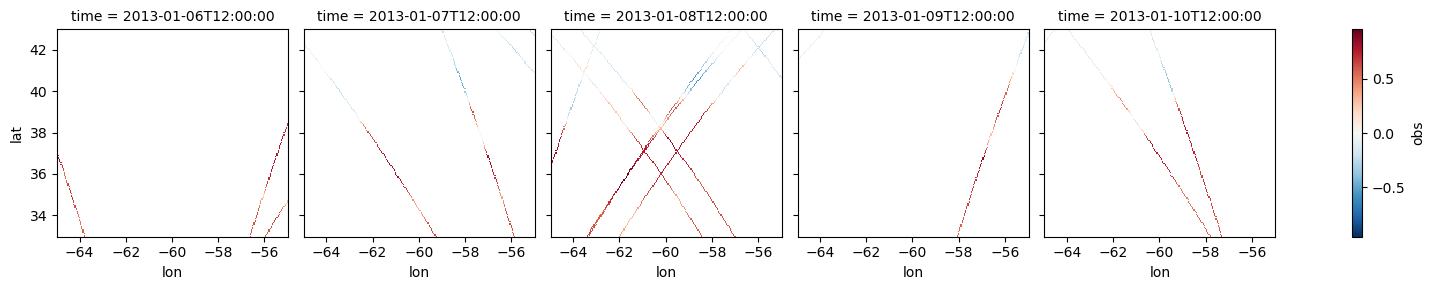

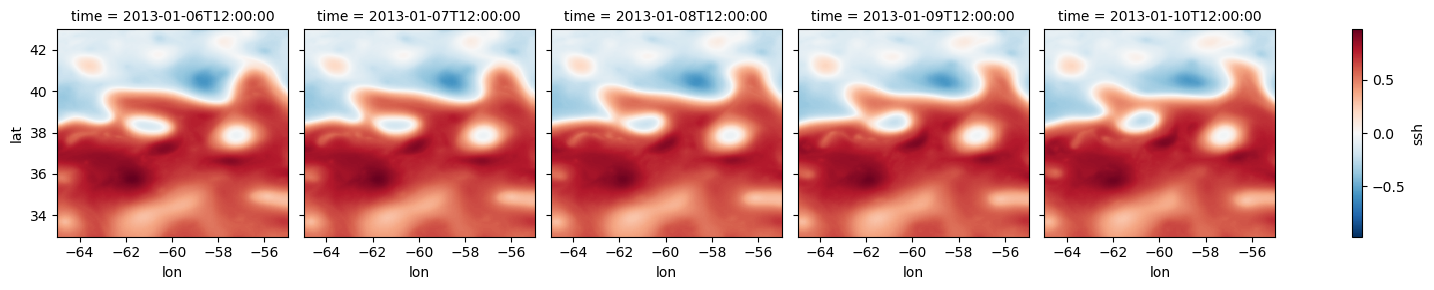

In [143]:
task = get_task('osse_gf_nadir')

patcher_kw = dict(patches={'time': 5}, strides={'time': 1})

train_patcher = patcher_from_osse_task(task, patcher_kw=patcher_kw)
test_patcher = patcher_from_osse_task(task, patcher_kw=patcher_kw, split='test')

print('\nTrainVal', train_patcher, '\n')
print('\nTest', test_patcher, '\n')

plot_item(train_patcher)

```yaml

data: {obs: '${...data.outputs.swot_gridded}', ssh: '${...data.outputs.ssh}'}
domain:
  lat: [33, 43]
  lon: [-65, -55]
name: DC2020 OSSE Gulfstream Nadir + Swot
splits:
  test: ['2012-10-22', '2012-12-02']
  trainval: ['2013-01-01', '2013-09-30']


```


TrainVal XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 273), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 5), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('variable', 1), ('time', 269), ('lat', 1), ('lon', 1)]) 


Test XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 273), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 5), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('variable', 1), ('time', 269), ('lat', 1), ('lon', 1)]) 



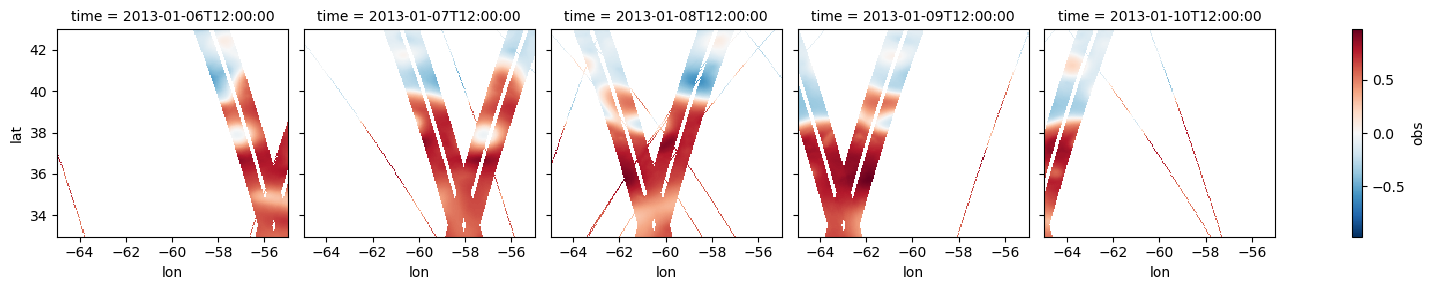

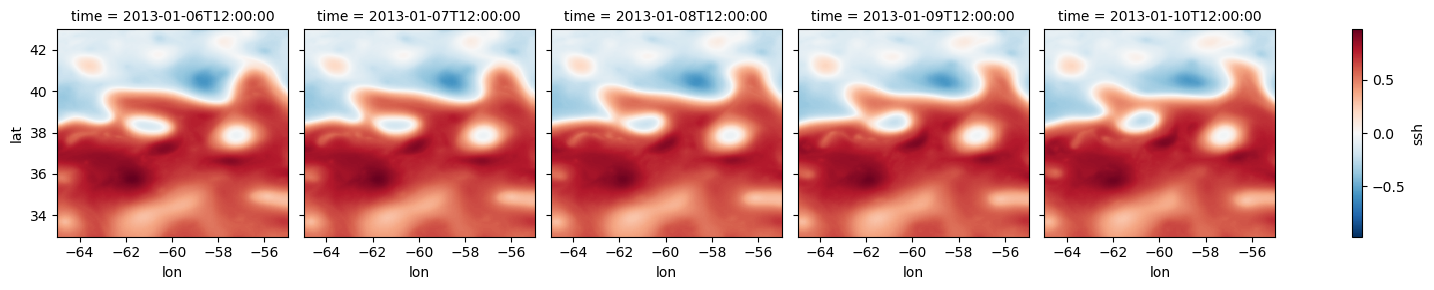

In [144]:
task = get_task('osse_gf_nadirswot')

patcher_kw = dict(patches={'time': 5}, strides={'time': 1})

train_patcher = patcher_from_osse_task(task, patcher_kw=patcher_kw)
test_patcher = patcher_from_osse_task(task, patcher_kw=patcher_kw, split='test')

print('\nTrainVal', train_patcher, '\n')
print('\nTest', test_patcher, '\n')

plot_item(train_patcher)

```yaml

data: {obs: '${...data.outputs.nadir_gridded}', ssh: '${...data.outputs.ssh}', sst: '${...data.outputs.sst}'}
domain:
  lat: [33, 43]
  lon: [-65, -55]
name: OSSE Gulfstream Nadir + SST
splits:
  test: ['2012-10-22', '2012-12-02']
  trainval: ['2013-01-01', '2013-09-30']


```


TrainVal XArray Patcher
DataArray size: OrderedDict([('variable', 3), ('time', 273), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 3), ('time', 5), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('variable', 1), ('time', 269), ('lat', 1), ('lon', 1)]) 


Test XArray Patcher
DataArray size: OrderedDict([('variable', 3), ('time', 42), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 3), ('time', 5), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('variable', 1), ('time', 38), ('lat', 1), ('lon', 1)]) 



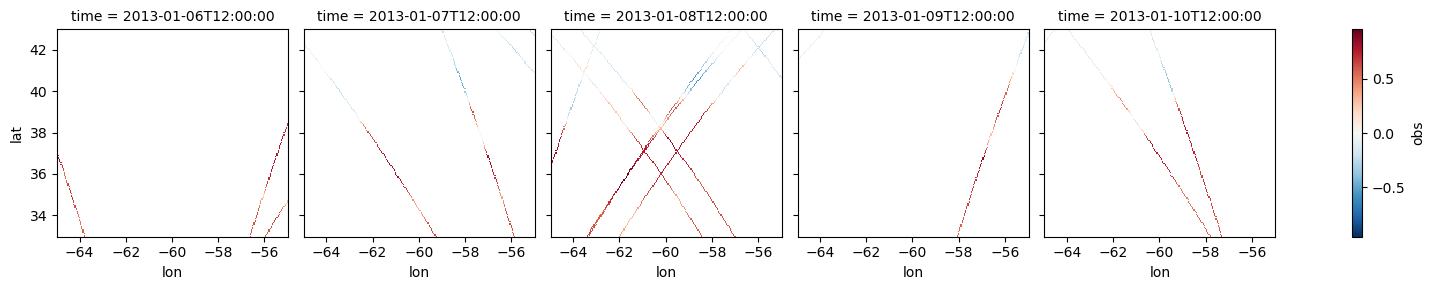

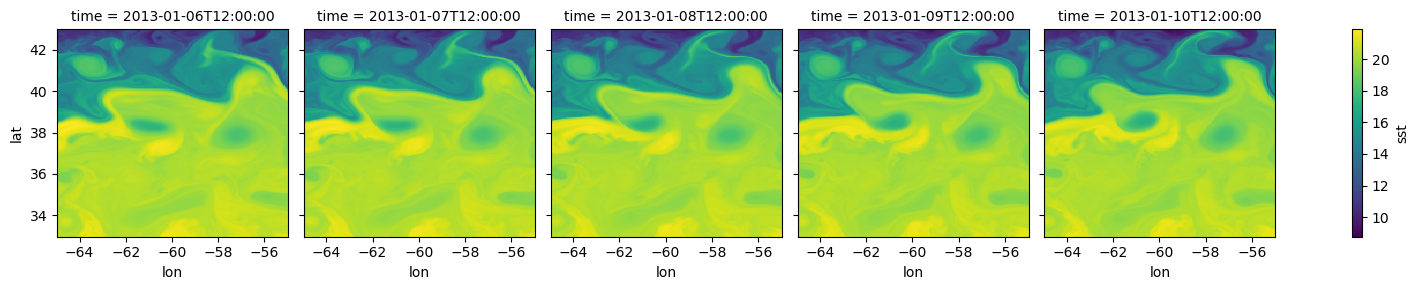

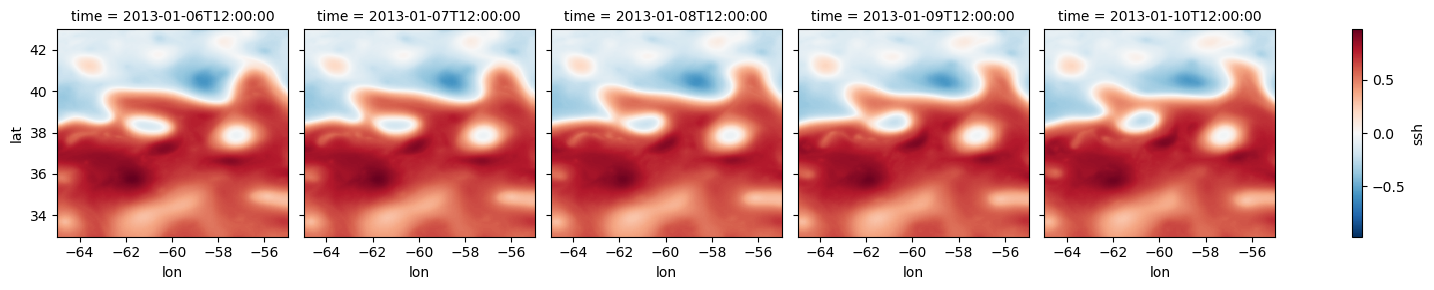

In [147]:
task = get_task('osse_gf_nadir_sst')

patcher_kw = dict(patches={'time': 5}, strides={'time': 1})

train_patcher = patcher_from_osse_task(task, patcher_kw=patcher_kw)
test_patcher = patcher_from_osse_task(task, patcher_kw=patcher_kw, split='test')

print('\nTrainVal', train_patcher, '\n')
print('\nTest', test_patcher, '\n')

plot_item(train_patcher)

## OSE

In [175]:

def patcher_from_ose_task(task, tgt_grid_resolution, patcher_kw, ref_var='ssh',  split='train'):
    default_domain_limits = dict(
        time=task.splits[split],
        lat=task.domain.lat,
        lon=task.domain.lon,
    )
    domain_limits = {**default_domain_limits, **patcher_kw.get('domain_limits', {})}
    
    select = lambda da: (
        da.sel(time=slice(*domain_limits['time']))
        .where(lambda da: da.lat>domain_limits['lat'][0], drop=True)
        .where(lambda da: da.lon>domain_limits['lon'][0], drop=True)
        .where(lambda da: da.lat<domain_limits['lat'][1], drop=True)
        .where(lambda da: da.lon<domain_limits['lon'][1], drop=True)
    )
    
    tgt_grid = xr.Dataset(coords=dict(
        lat=np.arange(*domain_limits['lat'], tgt_grid_resolution['lat']),
        lon=np.arange(*domain_limits['lon'], tgt_grid_resolution['lon']),
        time=pd.date_range(*domain_limits['time'], freq=tgt_grid_resolution['time']),
    ))
    
    data =  dict(
        train=xr.combine_nested([v().pipe(select) for k, v in task.data['train'].items()], concat_dim='time'),
        test=xr.combine_nested([v().pipe(select) for k, v in task.data['test'].items()], concat_dim='time')
    )
    
    da = xr.Dataset(
        {
            k: obgrid.coord_based_to_grid(v.to_dataset(name='ssh'), tgt_grid).ssh
            for k,v in data.items()
        }
    ).to_array()
    

    return obds.XRDABatcher(da, **patcher_kw)

```yaml

data:
  test: {c2: '${....data.outputs.c2}'}
  train: {alg: '${....data.outputs.alg}', h2g: '${....data.outputs.h2g}', j2g: '${....data.outputs.j2g}',
    j2n: '${....data.outputs.j2n}', j3: '${....data.outputs.j3}', s3a: '${....data.outputs.s3a}'}
domain:
  lat: [33, 43]
  lon: [-65, -55]
name: DC2021 OSE Gulfstream
splits:
  test: ['2017-01-01', '2017-12-31']
  train: ['2016-12-01', '2018-01-31']


```


TrainVal XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 427), ('lat', 100), ('lon', 100)])
Patches:        OrderedDict([('variable', 2), ('time', 5), ('lat', 100), ('lon', 100)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('variable', 1), ('time', 423), ('lat', 1), ('lon', 1)]) 


Test XArray Patcher
DataArray size: OrderedDict([('variable', 2), ('time', 365), ('lat', 100), ('lon', 100)])
Patches:        OrderedDict([('variable', 2), ('time', 5), ('lat', 100), ('lon', 100)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('variable', 1), ('time', 361), ('lat', 1), ('lon', 1)]) 



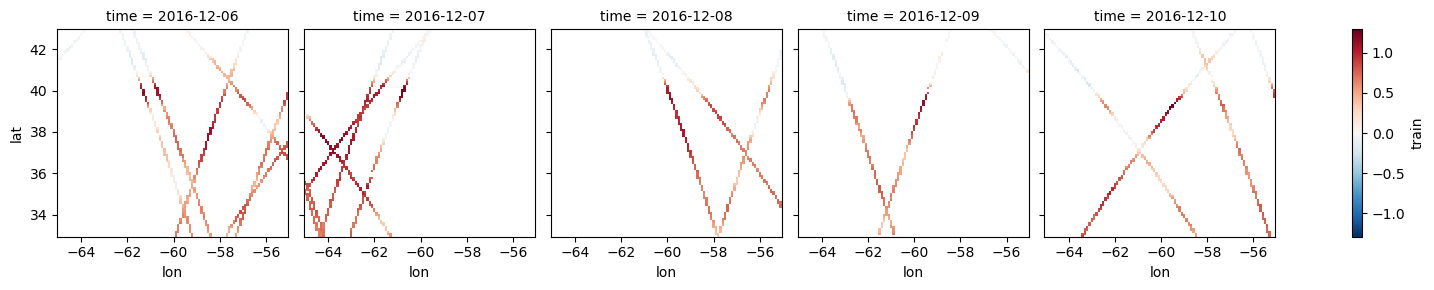

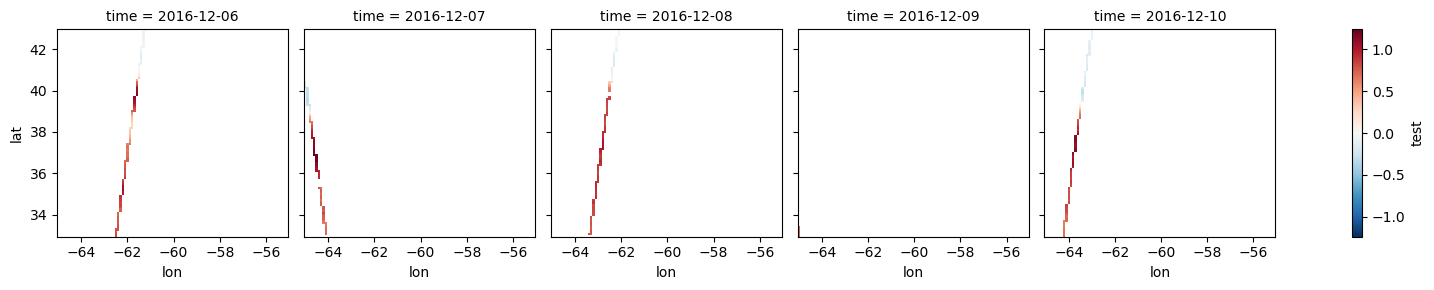

In [176]:
task = get_task('ose_gf')

patcher_kw=dict(patches={'time': 5}, strides={'time': 1})
tgt_grid_resolution=dict(lat=0.1, lon=0.1, time='1D')

train_patcher = patcher_from_ose_task(task, tgt_grid_resolution=tgt_grid_resolution, patcher_kw=patcher_kw)
test_patcher = patcher_from_ose_task(task, tgt_grid_resolution=tgt_grid_resolution, patcher_kw=patcher_kw, split='test')

print('\nTrainVal', train_patcher, '\n')
print('\nTest', test_patcher, '\n')

plot_item(train_patcher)

# Task 1 Walkthrough and visualization:

In [ ]:
def plot_t0(d1, d2, figsize=(9, 3)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    d1.isel(time=0).plot(ax=ax1)
    d2.isel(time=0).plot(ax=ax2)

In [ ]:
task = get_task('osse_gf_nadir')

In [ ]:
obs_da, ssh_da = task.data.obs(), task.data.ssh()


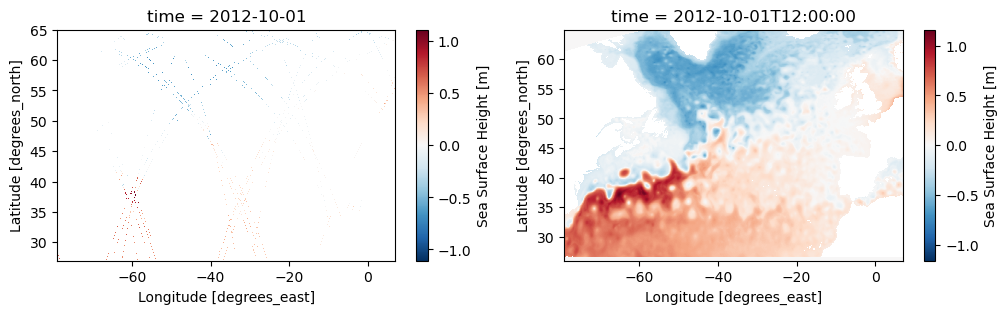

In [ ]:
plot_t0(obs_da, ssh_da, figsize=(12, 3))

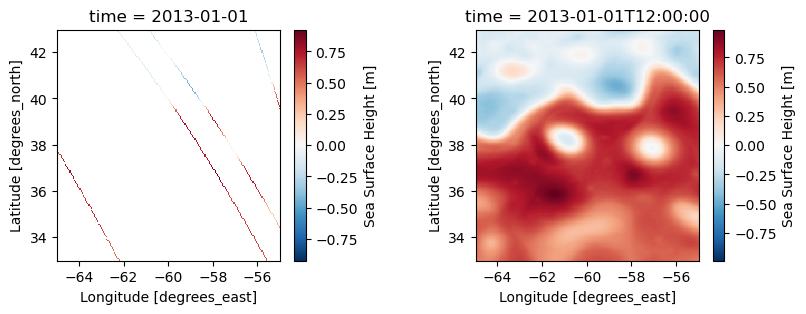

In [77]:
train_select = lambda d: d.sel(
    time=slice(*task.splits.trainval),
    lat=slice(*task.domain.lat),
    lon=slice(*task.domain.lon)
)
train_obs, train_ssh = train_select(obs_da), train_select(ssh_da)
plot_t0(train_obs, train_ssh)
plt.subplots_adjust(wspace=0.5)


In [78]:
train_da = xr.Dataset(dict(obs=train_obs.assign_coords(train_ssh.coords), ssh=train_ssh)).to_array()
train_da.dims

('variable', 'time', 'lat', 'lon')

In [45]:
patcher = obds.XRDABatcher(train_da, patches=dict(time=5), strides=dict(time=1))
patcher

XArray Patcher
DataArray Size: OrderedDict([('variable', 2), ('time', 273), ('lat', 200), ('lon', 200)])
Patches:        OrderedDict([('variable', 2), ('time', 5), ('lat', 200), ('lon', 200)])
Strides:        OrderedDict([('variable', 1), ('time', 1), ('lat', 1), ('lon', 1)])
Num Items:    OrderedDict([('variable', 1), ('time', 269), ('lat', 1), ('lon', 1)])

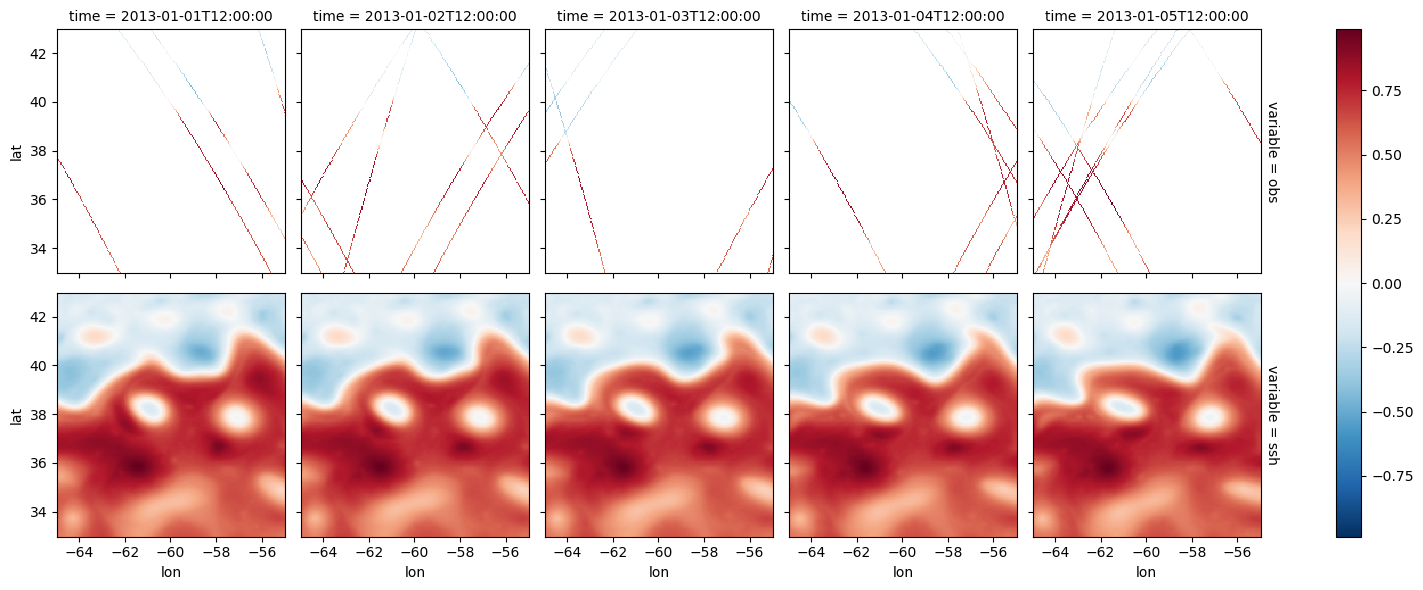

In [46]:
patcher[0].plot(row='variable', col='time')